In [17]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from astropy import constants as c
from astropy import units as u
import itertools
import copy
from tqdm import tqdm

import sys
plt.style.use('vedant')

## Initial Conditions from Shen+18

In [18]:
# N = 25

# m1_grid = np.linspace(*m1_range, N)
# m2_grid = np.linspace(*m2_range, N)
# a3_grid = np.linspace(*a3_range, N)

# mass_grid = np.array(list(itertools.product(m1_grid, m2_grid)))
# param_grid = np.array(list(itertools.product(mass_grid, a3_grid)))
# print(len(param_grid))

def get_radius(m):
    return 0.0126 * (m)**(-1/3) * (1 - (m / 1.456)**(4/3)) ** (1/2)

def rlof(m1, m2):
    t1 = get_radius(m2) / 0.49
    t2 = (m1 / m2) ** (2/3)
    t3 = np.log(1 + (m2 / m1) ** (1/3))
    
    return t1 * (0.6 + t2 * t3)

# def get_m2(m1, v_runaway):
#     return ((((c.G * (m1 * c.M_sun)**2) / 
#(v_runaway * 1000 * u.m / u.s)**2) / (rlof(m1, m2) * c.R_sun)) - m1 * c.M_sun) / c.M_sun

def v_runaway(m1, m2, a):
    return np.sqrt( (c.G * (m1 * c.M_sun)**2) / ((m1 + m2) * c.M_sun * a * c.R_sun) ).value / 1000

In [19]:
def critical_orbit(m1, m2, ab): # Li 2016
    
    mu = m2 / (m1 + m2)
    
    t1 = 1.6
    t2 = 4.12 * mu
    t3 = -5.09 * mu**2
    
    return ab * (t1 + t2 + t3)

In [20]:
critical_orbit(1.1, 0.5, 0.05)

0.11952148437500001

In [21]:
m1_range = [0.85, 1.1]
m2_range = [0.4, 0.6]
a3_range = [0.05, 5]




m1 = 1
m2 = 0.6

a = rlof(m1, m2)
a_crit = critical_orbit(m1, m2, a)

print(v_runaway(m1, m2, a))
print(a)
print(a_crit)

m3 = 1e20
a3_grid = np.linspace(a_crit, 10*a_crit, 25)

1793.6679041487414
0.03705830694038669
0.09002273406284249


  8%|▊         | 2/25 [00:03<00:36,  1.60s/it]

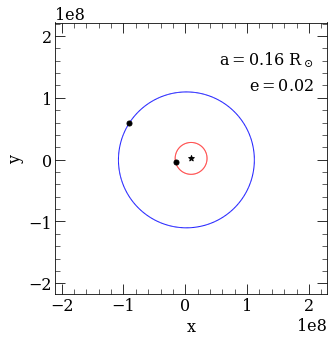

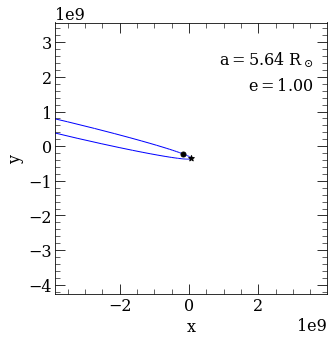

 12%|█▏        | 3/25 [00:14<01:33,  4.24s/it]

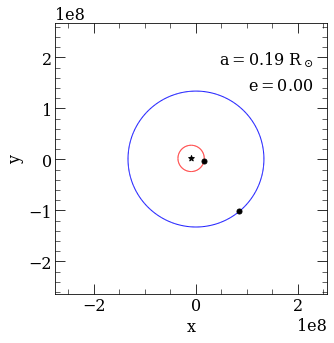

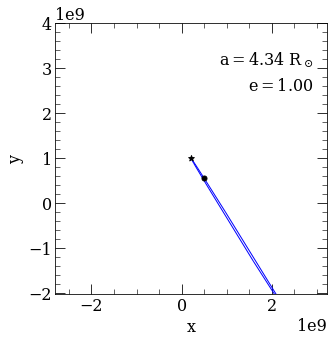

 16%|█▌        | 4/25 [00:20<01:45,  5.01s/it]

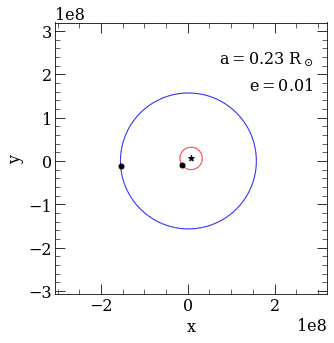

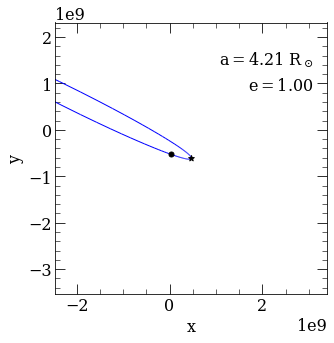

 20%|██        | 5/25 [00:28<01:53,  5.67s/it]

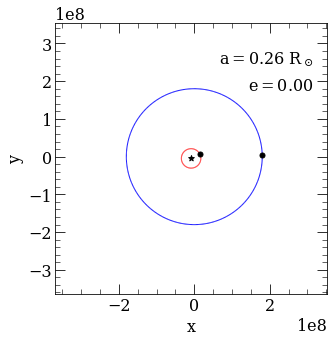

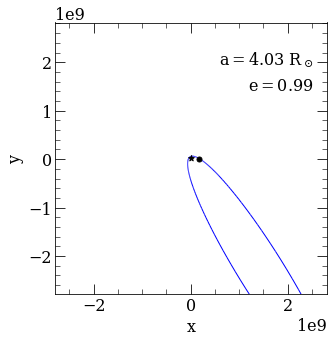

 24%|██▍       | 6/25 [00:35<01:58,  6.22s/it]

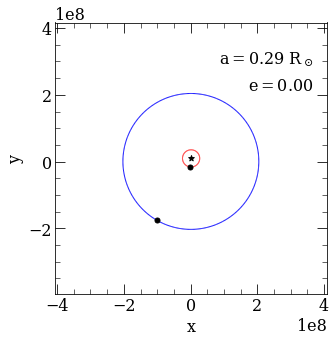

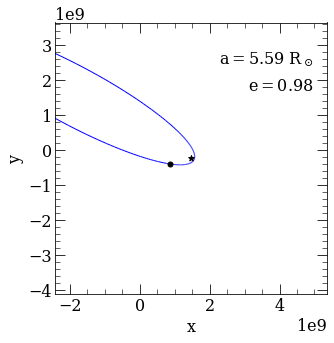

 28%|██▊       | 7/25 [00:42<01:57,  6.55s/it]

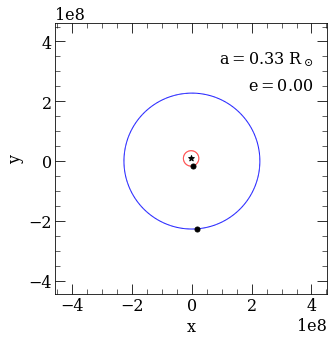

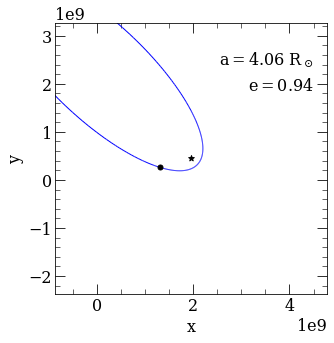

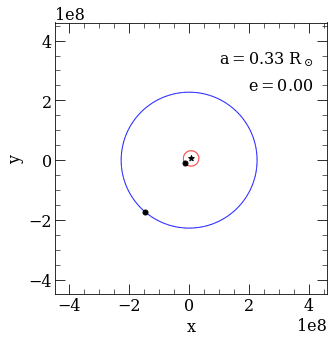

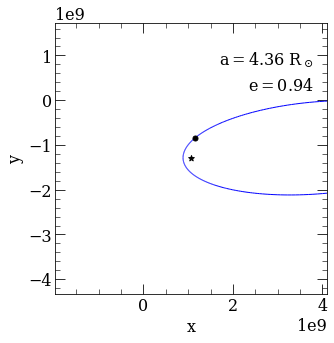

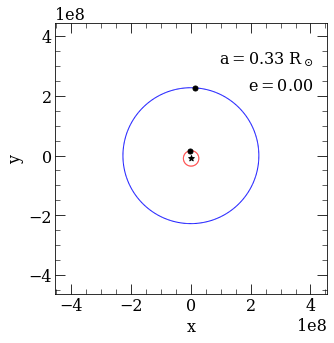

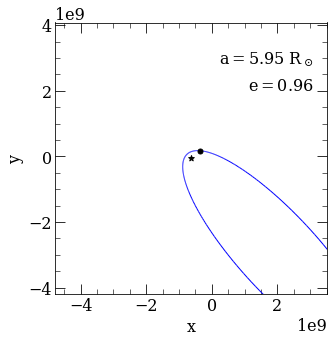

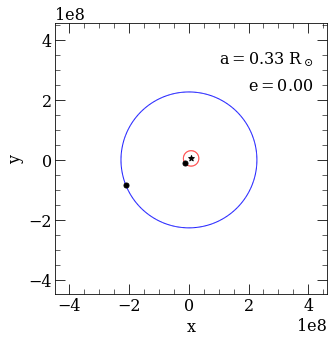

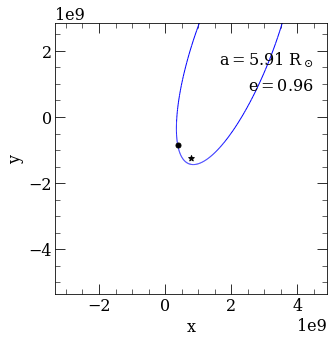

100%|██████████| 25/25 [03:01<00:00,  7.24s/it]


In [23]:
ecc = [];
sma = [];
init_sma = [];

nmc = 500

for kk,a3 in enumerate(tqdm(a3_grid)):
    
    for ii in range(nmc):
        
        init_sma.append(a3)
        
        period = (2 * np.pi * np.sqrt((a3 * c.R_sun)**3 / (c.G * (m1 + m2) * c.M_sun))).value

        sim = rebound.Simulation()

        sim.G = c.G.value
        sim_m1 = m1 * c.M_sun.value
        sim_m2 = m2 * c.M_sun.value
        sim_a = a * c.R_sun.value 
        sim_d = a3 * c.R_sun.value

        sim.add(m = sim_m1, hash = 'wd1')
        sim.add(m = sim_m2, a = sim_a, hash = 'wd2')
        sim.add(m = 1e20, a = sim_d, hash = 'planet')

        sim.move_to_com()

        n_orbit = np.random.random()

        sim_time = period * n_orbit
        sim.dt = period / 100
        
        sim.simulationarchive_snapshot("pre_snap.bin")

        sim.integrate(sim.t + sim_time)
        
        sim.simulationarchive_snapshot("archive.bin")

        if sim.particles[2].e > 1:
            ecc.append(np.nan)
            sma.append(np.nan)
            print('unstable')
            continue
                
        sim.remove(hash='wd1')

        sim.integrate(sim.t + sim_time)

        ecc.append(sim.particles[1].e)
        sma.append(sim.particles[1].a / c.R_sun.value)
        
#         if sim.particles[1].a/c.R_sun.value > 4 and \
#                     sim.particles[1].e < 1 and sim.particles[1].a/c.R_sun.value < 6:
            
#             init_sim = rebound.SimulationArchive("pre_snap.bin")[-1]
#             init_sim.simulationarchive_snapshot("success.bin")
#             print(sim.particles[1].e)
#             print(n_orbit)
#             #raise
        
        
        if sim.particles[1].a/c.R_sun.value > 4 and \
                    sim.particles[1].e < 1 and sim.particles[1].a/c.R_sun.value < 6:
        
            init_sim = rebound.SimulationArchive("archive.bin")[-1]
            fig, ax = rebound.OrbitPlot(init_sim, orbit_type="solid", Narc = 500, color = ['red', 'blue'])
            x = init_sim.particles[0].x
            y = init_sim.particles[0].y
            plt_a = init_sim.particles[2].a
            
            plt.text(0.95, 0.9, '$a = %.2f\ R_\odot$' %(plt_a / c.R_sun.value), ha = 'right', va = 'top',
                    transform = ax.transAxes)
            plt.text(0.95, 0.8, '$e = %.2f$' %(init_sim.particles[2].e), ha = 'right', va = 'top',
                    transform = ax.transAxes)

            plt.xlim(x - 2*plt_a, x + 2*plt_a)
            plt.ylim(y - 2*plt_a, y + 2*plt_a)
            
            plt.show()
                        
            fig, ax = rebound.OrbitPlot(sim, orbit_type="solid", Narc = 500, color = ['blue'])
            x = sim.particles[0].x
            y = sim.particles[0].y
            plt_a = sim.particles[1].a
            
            plt.text(0.95, 0.9, '$a = %.2f\ R_\odot$' %(plt_a / c.R_sun.value), ha = 'right', va = 'top',
                    transform = ax.transAxes)
            
            plt.text(0.95, 0.8, '$e = %.2f$' %(sim.particles[1].e), ha = 'right', va = 'top',
                    transform = ax.transAxes)

            plt.xlim(x - plt_a, x + plt_a)
            plt.ylim(y - plt_a, y + plt_a)
            
            plt.show()

In [8]:
print('probability = %.3f' %(np.sum(np.array(sma) > 3.5) / len(sma)))

probability = 0.000


Text(0, 0.5, 'Initial SMA ($R_\\odot$)')

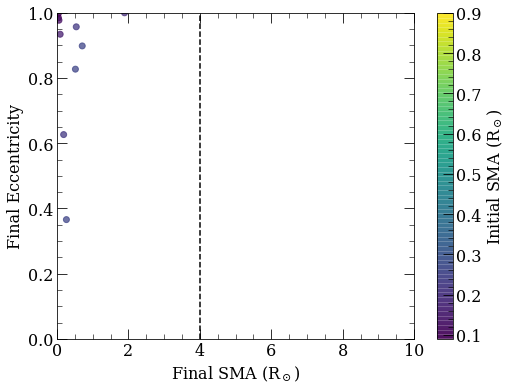

In [9]:
plt.scatter(sma, ecc, c = init_sma, cmap = 'viridis', alpha = 0.75)
plt.ylim(0, 1)
plt.xlim(0, 10)
cbar = plt.colorbar()
plt.axvline(4, linestyle = '--', color = 'k')

plt.ylabel('Final Eccentricity')
plt.xlabel('Final SMA ($R_\odot$)')

cbar.ax.set_ylabel('Initial SMA ($R_\odot$)')

In [10]:
sim_time / sim.dt

28.714860072968136

In [11]:
period

6758.11165999608

Text(0, 0.5, 'Final SMA ($R_\\odot$)')

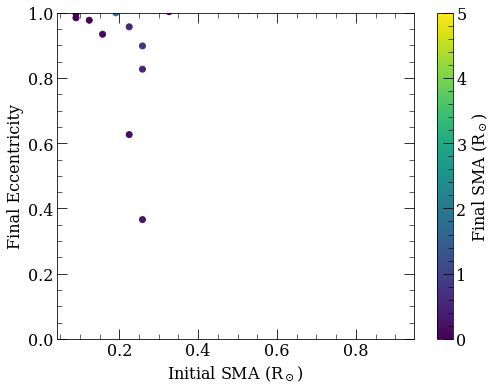

In [12]:
plt.scatter(init_sma, ecc, c = sma, cmap = 'viridis', vmin = 0, vmax = 5)
plt.ylim(0, 1)
plt.ylabel('Final Eccentricity')
plt.xlabel('Initial SMA ($R_\odot$)')
cbar = plt.colorbar()

cbar.ax.set_ylabel('Final SMA ($R_\odot$)')

Text(0, 0.5, 'Final Eccentricity')

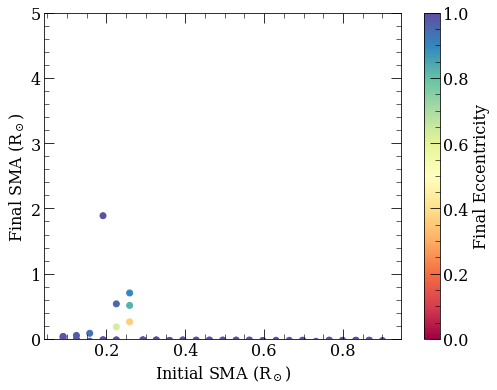

In [13]:
plt.scatter(init_sma, sma, c = ecc, vmin = 0, vmax = 1)
plt.ylim(0, 5)

cbar = plt.colorbar()

plt.ylabel('Final SMA ($R_\odot$)')
plt.xlabel('Initial SMA ($R_\odot$)')

cbar.ax.set_ylabel('Final Eccentricity')

## Animate 1

In [14]:
from IPython import display
import pylab as pl

In [16]:
sim = rebound.SimulationArchive("success.bin")[-1]

init_sim = sim

sim.move_to_com()

n_orbit = 0.2637999259236379

sim_time = period * n_orbit

sim.dt = sim_time / 2
i = 0

while sim.t <= sim_time:
    print(i)
    try:
        sim.integrate(sim.t + sim.dt)

        rebound.OrbitPlot(sim, orbit_type="solid", Narc = 500, color = ['red', 'blue'])

        x = init_sim.particles[0].x
        y = init_sim.particles[0].y
        plt_a = init_sim.particles[2].a

        plt.xlim(x - 2*plt_a, x + 2*plt_a)
        plt.ylim(y - 2*plt_a, y + 2*plt_a)
        
        plt.savefig('frames/%i.png'%i, dpi = 150)
        plt.close()
        i+=1
    except KeyboardInterrupt:
        raise

sim.particles[0].m = 0.05 * c.M_sun.value
print('kaboom')
j = 0;
while sim.t <= 2 * sim_time:
    print(i)
    try:
        sim.integrate(sim.t + sim.dt)

        rebound.OrbitPlot(sim, orbit_type="solid", Narc = 500, color = ['blue'])

        x = init_sim.particles[0].x
        y = init_sim.particles[0].y
        #plt_a = init_sim.particles[2].a

        plt.xlim(x - 2*plt_a, x + 2*plt_a)
        plt.ylim(y - 2*plt_a, y + 2*plt_a)
        
        if j == 0:
            plt.text(0.95, 0.1, 'KABOOM', ha = 'right', va = 'bottom',
                     transform = plt.gca().transAxes)
        
        plt.savefig('frames/%i.png'%i, dpi = 150)
        plt.close()
        i+=1
        j+=1
    except KeyboardInterrupt:
        raise

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27